# Test point-based registration

In [68]:
%matplotlib widget
import numpy as np
import os
import open3d as o3d
import copy
import time
import matplotlib.pyplot as plt

import planeslam.io as io

Read in airsim LiDAR and pose data

In [69]:
# Read in point cloud data
binpath = os.path.join(os.getcwd(),'..', '..', 'data', 'airsim', 'blocks_20_samples_1', 'lidar', 'Drone0')
PC_data = io.read_lidar_bin(binpath)

In [70]:
# Read in ground-truth poses (in drone local frame)
posepath = os.path.join(os.getcwd(),'..', '..', 'data', 'airsim', 'blocks_20_samples_1', 'poses', 'Drone0')
drone_positions, drone_orientations = io.read_poses(posepath)

Open3D ICP registration

In [71]:
# Visualization helper
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp],
                                      zoom=0.4459,
                                      front=[0.9288, -0.2951, -0.2242],
                                      lookat=[1.6784, 2.0612, 1.4451],
                                      up=[-0.3402, -0.9189, -0.1996])

In [72]:
# Initialize source and target
def initalize_source_and_target(source_data, target_data):
    source = o3d.geometry.PointCloud()
    source.points = o3d.utility.Vector3dVector(source_data)
    source.estimate_normals()
    source.orient_normals_towards_camera_location()

    target = o3d.geometry.PointCloud()
    target.points = o3d.utility.Vector3dVector(target_data)
    target.estimate_normals()
    target.orient_normals_towards_camera_location()

    return source, target

source, target = initalize_source_and_target(PC_data[0], PC_data[1])

In [73]:
# Visualize
o3d.visualization.draw_geometries([source,target])

In [74]:
# Initial guess transform 
trans_init = np.eye(4)
threshold = 0.02

evaluation = o3d.pipelines.registration.evaluate_registration(
    source, target, threshold, trans_init)
print(evaluation)

RegistrationResult with fitness=4.595588e-04, inlier_rmse=1.658737e-02, and correspondence_set size of 3
Access transformation to get result.


In [75]:
# Point-to-point ICP
print("Apply point-to-point ICP")

start_time = time.time()
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint())
print("Elapased time: ", time.time() - start_time)
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
draw_registration_result(source, target, reg_p2p.transformation)

Apply point-to-point ICP
Elapased time:  0.011945009231567383
RegistrationResult with fitness=6.280637e-03, inlier_rmse=1.329315e-02, and correspondence_set size of 41
Access transformation to get result.
Transformation is:
[[ 9.62607006e-01  7.05381633e-05  2.70901728e-01 -9.08054546e-01]
 [-1.56330597e-04  9.99999944e-01  2.95113544e-04 -6.75400308e-03]
 [-2.70901692e-01 -3.26428594e-04  9.62606964e-01 -4.43856240e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


## Point-to-plane changes

Open3D's point-to-plane (and standard ICP) use a distance threshold for getting robust correspondences. Essentially all correspondences with distance greater than threshold are removed. In order to get point-to-point to work I had to change the threshold from 0.02 to anything greater than around 0.5. It is pretty robust once it has enough correspondences

In [76]:
threshold = 1.
print("Apply point-to-plane ICP")

def p2l_ICP(source, target, threshold, trans_init):
    start_time = time.time()
    reg_p2p = o3d.pipelines.registration.registration_icp(
        source, target, threshold, trans_init,
        o3d.pipelines.registration.TransformationEstimationPointToPlane())
    eval_time = time.time() - start_time
    return reg_p2p, eval_time

reg_p2l, eval_time = p2l_ICP(source, target, threshold, trans_init)
print("Elapased time: ", eval_time)
print(reg_p2l)
print("Transformation is:")
print(reg_p2l.transformation)
draw_registration_result(source, target, reg_p2l.transformation)

Apply point-to-plane ICP
Elapased time:  0.02706766128540039
RegistrationResult with fitness=6.810662e-01, inlier_rmse=4.710465e-01, and correspondence_set size of 4446
Access transformation to get result.
Transformation is:
[[ 9.61876726e-01  4.09679534e-05  2.73483386e-01 -1.16147564e+00]
 [-2.02246849e-04  9.99999822e-01  5.61528045e-04  1.83018598e-02]
 [-2.73483315e-01 -5.95431910e-04  9.61876563e-01  3.60907755e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


Full Trajectory Point-to-Plance Open3D ICP Registration

In [77]:
# Full Trajectory Point-to-point ICP
def full_trajectory_p2l_ICP(trajectory, threshold = 1, init_w_RANSAC = False, print_results = False, plot_results = False):
    # Initialize vectors to store the results and evaluation times
    traj_reg_p2l = []
    traj_eval_time = []

    # Loop through the trajectory staring with the 2nd point cloud
    for i in range(1, len(trajectory)):
        # Initialize the source and target point clouds
        source, target = initalize_source_and_target(trajectory[i], trajectory[i-1])

        # Define the threshold and initial transform
        if init_w_RANSAC:
            trans_init = np.eye(4)
        else:
            trans_init = np.eye(4)

        reg_p2l, eval_time = p2l_ICP(source, target, threshold, trans_init)
        traj_reg_p2l.append(reg_p2l)
        traj_eval_time.append(eval_time)

        if print_results:
            print("Elapased time: ", eval_time)
            print(reg_p2l)

        if plot_results:
            draw_registration_result(source, target, reg_p2l.transformation)

    return traj_reg_p2l, traj_eval_time 

traj_reg_p2l, traj_eval_time = full_trajectory_p2l_ICP(PC_data, print_results=False, plot_results=False)
traj_fitness = [reg_p2l.fitness for reg_p2l in traj_reg_p2l]
traj_inlier_rmse = [reg_p2l.inlier_rmse for reg_p2l in traj_reg_p2l]
traj_transformation = [reg_p2l.transformation for reg_p2l in traj_reg_p2l]

(0.0, 10.0)

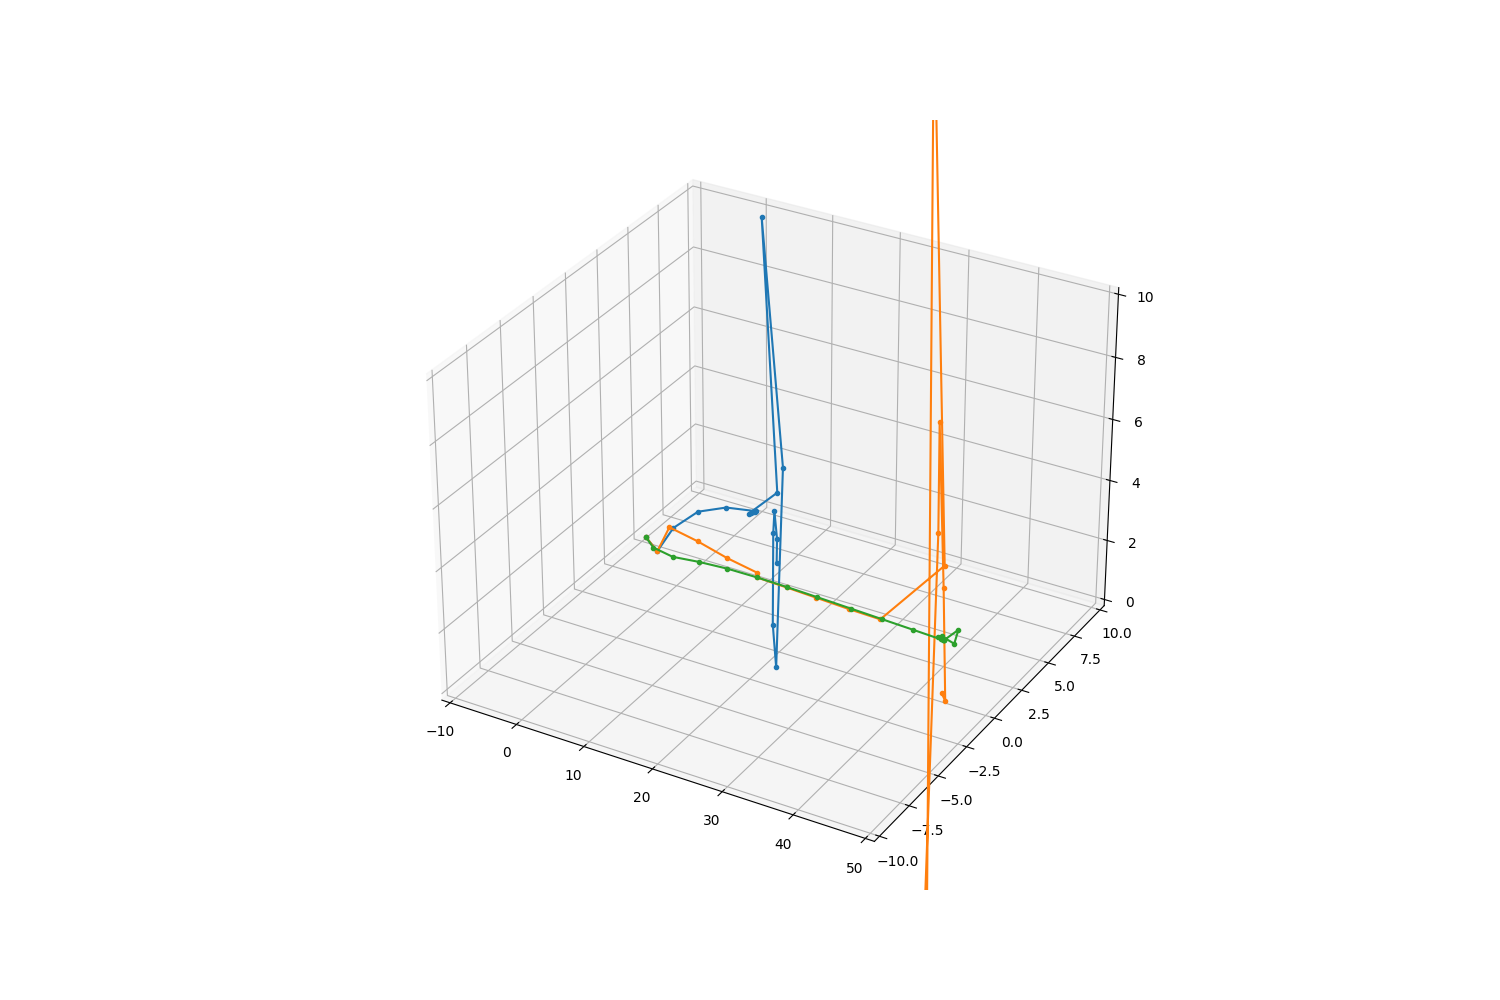

In [81]:
# reconstructing the trajectory from only the starting point
traj = [np.append(drone_positions[0], 1)]
for transformation in traj_transformation:
    traj.append(transformation @ traj[-1])
traj = np.array(traj)[:,:3]

# reconstructing the trajectory from applying the transformation to the previous point of the ground truth trajectory
drone_positions_4 = np.hstack((drone_positions, np.ones((len(drone_positions),1))))
traj2 = [drone_positions_4[0]]
for i in range(len(traj_transformation)):
    traj2.append(traj_transformation[i] @ drone_positions_4[i])
traj2 = np.array(traj2)[:,:3]

# Plot the points
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.plot3D(traj[:,0], traj[:,1], -traj[:,2], marker='.') 
ax.plot3D(traj2[:,0], traj2[:,1], -traj2[:,2], marker='.') 
ax.plot3D(drone_positions[:,0], drone_positions[:,1], -drone_positions[:,2], marker='.') 
ax.axes.set_xlim3d(left=-10, right=50) 
ax.axes.set_ylim3d(bottom=-10, top=10) 
ax.axes.set_zlim3d(bottom=0, top=10)